# Digital twin simulator

## Optimizer code

**10/9/2022: This Juputer Notebook is for visualization use only. Some codes in the optimizer are not valid. The result is meaningless, but it does provide some insights. Remove all "solver='MOSEK'" to call the build-in solver if you do not have MOSEK.**

In [1]:
import numpy as np
import cvxpy as cp
from scipy import interpolate
import math
import timeit
from scipy.optimize import minimize


class Parameters:

    def __init__(self, 
                z0 = np.array([1,1,1,1]).reshape(4,1) ,
                v0 = np.array([0.333, 0.333, 0.333]).reshape(3,1) ,  
                Ts = 0.25, 
                base_tarriff_overstay = 1.0, 
                eff = 1, 
                soft_v_eta = 1e-3, 
                opt_eps = 0.0001, 
                TOU = np.ones((96,))):
        
        self.v0 = v0
        self.z0 = z0
        self.Ts = Ts
        self.base_tariff_overstay = base_tarriff_overstay
        self.TOU = TOU
        self.eff = eff # power efficiency
        self.dcm_choices = ['charging with flexibility', 'charging asap', 'leaving without charging']
        self.soft_v_eta = soft_v_eta #softening equality constraint for v; to avoid numerical error
        self.opt_eps = opt_eps
        
        assert len(self.TOU) == int(24 / self.Ts), "Mismatch between TOU cost array size and discretization steps"



class Problem:
    """
    time, int, user interval 
    duration, int, number of charging intervals 
    """
    def __init__(self, par ,**kwargs):
        self.par = par
        event = kwargs["event"]
        self.event = event
        
        self.user_time = event["time"]
        self.e_need = event["e_need"]

        self.user_duration = event["duration"]
        self.user_overstay_duration = round(event["overstay_duration"] / par.Ts) * par.Ts
        self.station_pow_max = event["pow_max"]
        self.station_pow_min = event["pow_min"]
        self.power_rate = event['power_rate']
        self.dcm_charging_flex_params = np.array([[ - self.power_rate * 0.0184 / 2], [ self.power_rate * 0.0184 / 2], [0], [0]])
        #% DCM parameters for choice 1 -- charging with flexibility
        self.dcm_charging_asap_params = np.array([[self.power_rate * 0.0184 / 2], [- self.power_rate * 0.0184 / 2], [0],[0.341 ]])
        #% DCM parameters for choice 2 -- charging as soon as possible
        self.dcm_leaving_params = np.array([[self.power_rate * 0.005 / 2], [self.power_rate * 0.005 / 2], [0], [-1 ]])


        
        #% DCM parameters for choice 3 -- leaving without charging
        self.THETA = np.vstack((self.dcm_charging_flex_params.T, self.dcm_charging_asap_params.T,
                     self.dcm_leaving_params.T))
        # problem specifications
        self.N_flex = self.user_duration # charging duration that is not charged, hour
        
        ### IS THIS CORRECT? WHATS SOC NEED REPRESENTS? 
        # self.N_asap = math.floor((self.user_SOC_need - self.user_SOC_init) *
        #                          self.user_batt_cap / self.station_pow_max / par.eff / par.Ts)

        ## HERE 12 IS SELF CODED 
        self.N_asap = math.ceil((self.e_need / self.station_pow_max / par.eff * int(1 / par.Ts)))
        temp = par.TOU

        while len(par.TOU) < self.user_time + self.user_duration: # if there is overnight chaarging

            par.TOU = np.concatenate([par.TOU,temp])

        self.TOU = par.TOU[self.user_time:(self.user_time + self.user_duration)]
        
        # self.TOU = interpolate.interp1d(np.arange(0, 24 - 0.25 + 0.1, 0.25), par.TOU, kind = 'nearest')(np.arange(self.user_time, 0.1 + self.user_time + self.user_duration - par.Ts, par.Ts)).T
        
        assert self.N_asap <= self.N_flex, print("Not enought time (n_asap,n_flex)",self.N_asap,self.N_flex)

class Optimization:

    def __init__(self, par, prb):
        self.Parameters = par
        self.Problem = prb
        self.opt_z = None
        self.opt_tariff_asap = None
        self.opt_tariff_flex = None
        self.opt_tariff_overstay = None

    def argmin_v(self, u, z):

        """

        Parameters 
        Decision Variables: 
        v: price [ sm(theta_flex, z), sm(theta_asap, z), sm(theta_leave, z) ], (3,1)

        """
  
        ### Read parameters 

 

        N_flex = self.Problem.N_flex
        N_asap = self.Problem.N_asap
        TOU = self.Problem.TOU
        station_pow_max = self.Problem.station_pow_max

        # mu = self.Parameters.mu
        THETA = self.Problem.THETA 
        soft_v_eta = self.Parameters.soft_v_eta
        delta_t = self.Parameters.Ts

        ### Decision Variables
        v = cp.Variable(shape = (3), pos = True)

        ### Define objective function
        # Flex Charging 
        # reg_flex =  cp.norm(u,2) * lam_x + cp.norm(z[0],2) * lam_z_c 
        
        f_flex = u.T @ (TOU - z[0]) * delta_t
            

        J_1 =  v[0] * (f_flex)
        
        # ASAP Charging
        # reg_asap =  cp.norm(z[1],2) * lam_z_uc 
        f_asap = cp.sum(station_pow_max * (TOU[:N_asap] - z[1])) * delta_t

        J_2 =  v[1] * (f_asap )
        
        # Leave
        # J_3 = v[2] * cp.sum(TOU[:N_asap] * station_pow_max) * delta_t
        J_3 = 0
        J =    J_1 + J_2 + J_3 

        ### Log sum function conjugate: negative entropy 
        # lse_conj = - cp.sum(cp.entr(v))
        # func = v.T @ (THETA @ z)
        # # J_4 = mu * (lse_conj - func) 
        # constraints += [ v <= np.array((1,1,1))] # What is this? 
        # constraints += [ cp.sum(v) >= 1 - soft_v_eta ]

        constraints = [v >= 0 ]
        constraints += [cp.sum(v) == 1 ]
        constraints += [v[2] <= 0.50 ]

        constraints += [ cp.log_sum_exp(THETA @ z) - cp.sum(cp.entr(v)) - v.T @ (THETA @ z) <= soft_v_eta ]
        
        ## Solve 
        obj = cp.Minimize(J)
        prob = cp.Problem(obj, constraints)
        prob.solve(solver='MOSEK')

        # try:
        #     # print(  "v",v.value)
        #     # print(  "status",prob.status)
        #     temp = v.value
        # except:
        #     print(  "status",prob.status)
        return np.round(v.value,4)

    def argmin_z(self, u, v):
        """
        Function to determine prices 

        Decision Variables: 
        z: price [tariff_flex, tariff_asap, tariff_overstay, leave = 1 ]

        Parameters: 
        u, array, power for flex charging 
        v, array with softmax results [sm_c, sm_uc, sm_y] (sm_y = leave)
        lam_x, regularization parameter for sum squares of the power var (u)
        lam_z_c, regularization parameter for sum squares of the price flex (u)
        lam_z_uc, regularization parameter for sum squares of the price asap (u)
        lam_h_c, regularization parameter for g_flex
        lam_h_uc, regularization parameter for g_asap
        N_flex: timesteps arrival to departure 
        N_asap: timesteps required when charging at full capacity

        """
        if sum(v) < 0 | (np.sum(v) < 1 - self.Parameters.soft_v_eta) | (np.sum(v) > 1 + self.Parameters.soft_v_eta):
            raise ValueError('[ ERROR] invalid $v$')
        
        ### Read parameters 
        N_flex = self.Problem.N_flex
        N_asap = self.Problem.N_asap
        TOU = self.Problem.TOU
        station_pow_max = self.Problem.station_pow_max
        vehicle_power_rate = self.Problem.power_rate
        delta_t = self.Parameters.Ts
        soft_v_eta = self.Parameters.soft_v_eta
        THETA = self.Problem.THETA 

        ### Decision Variables
        
        z = cp.Variable(shape = (4), pos = True)

        f_flex = u.T @ (TOU - z[0]) * delta_t
        # g_flex = lam_h_c * cp.inv_pos(z[2])

        J_1 =  v[0] * (f_flex)
        
        # ASAP Charging
        f_asap = cp.sum(station_pow_max * (TOU[:N_asap] - z[1])) * delta_t
        # g_asap =  lam_h_c* cp.inv_pos(z[2])
        
        J_2 =  v[1] * (f_asap)
        # Leave
        J_3 = 0

        J =  J_1 + J_2 + J_3


        ### Log sum function 
        # lse = cp.log_sum_exp(THETA @ z)
        # func = z.T @ (THETA.T @ v)
        # J_4 = mu * (lse - func) 
        constraints = [z[3] == 1]
        constraints += [ cp.log_sum_exp(THETA @ z) - cp.sum(cp.entr(v)) - v.T @ (THETA @ z) <= soft_v_eta ]
        constraints += [z <= 50]
        
        ## Solve 
        obj = cp.Minimize(J)
        prob = cp.Problem(obj, constraints)

        prob.solve(solver='MOSEK')
        # try:
        #     # print("z",np.round(z.value,5))
        #     temp = np.round(z.value,5)
        # except:
        #     print(  "z status",prob.status)
        
        
        return z.value


    def argmin_x(self, z, v):
        """
        Function to minimize charging cost. Flexible charging with variable power schedule
        Inputs: 

        Parameters: 
        z, array where [tariff_flex, tariff_asap, tariff_overstay, leave = 1 ]
        v, array with softmax results [sm_c, sm_uc, sm_y] (sm_y = leave)
        lam_x, regularization parameter for sum squares of the power var (u)
        lam_h_c, regularization parameter for g_flex
        lam_h_uc, regularization parameter for g_asap
        N_flex: timesteps arrival to departure 
        N_asap: timesteps required when charging at full capacity

        Parameters: 
        Decision Variables:
        SOC: state of charge (%)
        u: power (kW)

        Objective Function:
        Note: delta_k is not in the objective function!! 
        Check if it could make difference since power is kW cost is per kWh 

        Outputs
        u: power 
        SOC: SOC level 
        """
    
        ### Read parameters 
        N_flex = self.Problem.N_flex
        N_asap = self.Problem.N_asap
        TOU = self.Problem.TOU
        station_pow_max = self.Problem.station_pow_max
        vehicle_power_rate = self.Problem.power_rate
        e_need = self.Problem.e_need
        eff = 1
        # user_bat_cap = self.Problem.user_batt_cap  
        delta_t = self.Parameters.Ts 
        soft_v_eta = self.Parameters.soft_v_eta

        if sum(v) < 0 | (np.sum(v) < 1 - self.Parameters.soft_v_eta) | (np.sum(v) > 1 + self.Parameters.soft_v_eta):
            raise ValueError('[ ERROR] invalid $v$')
        

        ### Decision Variables
        e_delivered = cp.Variable(shape = (N_flex + 1))
        u = cp.Variable(shape = (N_flex))
        f_flex = u.T @ (TOU - z[0]) * delta_t
        # g_flex = lam_h_c * cp.inv_pos(z[2])
        
        J_1 =  v[0] * (f_flex)
        
        # ASAP Charging
        # reg_asap =  cp.norm(z[1],2) * lam_z_uc 
        f_asap = cp.sum(station_pow_max * (TOU[:N_asap] - z[1])) * delta_t
        # g_asap = lam_h_uc * cp.inv_pos(z[2])
        J_2 =  v[1] * (f_asap )
        # Leave
        # J_3 = v[2] * cp.sum(TOU[:N_asap] * station_pow_max * delta_t) 
        J_3 = 0

        J =    J_1 + J_2 + J_3


        ## Constraints 

        constraints =  [e_delivered[0] == 0]
        constraints += [e_delivered[N_flex] >=  e_need]
        constraints += [e_delivered <= e_need]
        constraints += [u >= 0]
        constraints += [u <= station_pow_max , u <= vehicle_power_rate]

        # System dynamics
        for i in range(0,N_flex ): 
            constraints += [e_delivered[i + 1] == e_delivered[i] + (eff * delta_t * u[i])]

        ## Solve 
        obj = cp.Minimize(J)
        prob = cp.Problem(obj, constraints)
        prob.solve(solver='MOSEK')
        
        # try:
        #    print("u:",np.round(u.value,2 ))
        # except:
        #    print(  "status",prob.status)
        return  u.value, e_delivered.value

    def run_opt(self):
        start = timeit.timeit()
        
        def J_func(z, u, v):
            ### Read parameters 
            N_asap = self.Problem.N_asap
            TOU = self.Problem.TOU
            station_pow_max = self.Problem.station_pow_max
            delta_t = self.Parameters.Ts 
            soft_v_eta = self.Parameters.soft_v_eta

            # reg_flex =  np.linalg.norm(u,2) * lam_x + z[0]**2 * lam_z_c
            
#             print(f'u.T = {u.T}')
#             print(f'z = {z}')
#             print(f'TOU = {TOU}')
#             print(f'delta_t = {delta_t}')
            
            f_flex = u.T @ (TOU - z[0]) * delta_t
            # g_flex = lam_h_c * 1 / z[2] 
            
            J_1 =  v[0] * (f_flex)
            
            # ASAP Charging
            # reg_asap =  z[1]**2 * lam_z_uc 
            f_asap = np.sum(station_pow_max * (TOU[:N_asap] - z[1])) * delta_t
            # g_asap = lam_h_uc * 1 / z[2] 
            J_2 =  v[1] * (f_asap )
            
            # Leave
            # Include the p_max 
            # J_3 = v[2] * np.sum(TOU[:N_asap]) * station_pow_max * delta_t
            J_3 = 0

            return  np.array([J_1 , J_2 , J_3], dtype=object)
        
        def charging_revenue(z, u):
            
            N_asap = self.Problem.N_asap
            TOU = self.Problem.TOU
            station_pow_max = self.Problem.station_pow_max

            delta_t = self.Parameters.Ts
            

            f_flex = u.T @ (z[0]- TOU) * delta_t
            ## u : kW , z: cents / kWh, TOU : cents / kWh , delta_t : 1 \ h
            f_asap = np.sum(station_pow_max * (z[1] - TOU[:N_asap])) * delta_t 

            return f_flex, f_asap

        itermax = 1000
        count = 0
        improve = np.inf
        
        # [z_c, z_uc, y, 1];
        # xk = np.ones((2 * self.Problem.N_flex + 1, 1)) # [soc0, ..., socN, u0, ..., uNm1]; - multiple dimensions 1 +  # of FLEX
        
        zk = self.Parameters.z0
        uk_flex = np.zeros((self.Problem.N_flex)) 
        vk = self.Parameters.v0                  # [sm_c, sm_uc, sm_y]

        ###     THIS VALUES ARE STORED FOR DEBUGGING     ## 
        
        Jk = np.zeros((itermax))
        rev_flex = np.zeros((itermax))
        rev_asap = np.zeros((itermax))
        z_iter = np.zeros((4,itermax))
        v_iter = np.zeros((3,itermax))
        J_sub = np.zeros((3,itermax))


        # print(J_func(zk, uk_flex, vk))

        while (count < itermax) & (improve >= 0) & (abs(improve) >= 0.0001):

            Jk[count]  = J_func(zk, uk_flex, vk).sum()
            J_sub[:,count] = J_func(zk, uk_flex, vk).reshape(3,)    
            rev_flex[count], rev_asap[count] = charging_revenue(zk, uk_flex)
            z_iter[:,count] = zk.reshape((4,))
            v_iter[:,count] = vk.reshape((3,))

            uk_flex, e_deliveredk_flex = self.argmin_x(zk, vk)
            
            vk = self.argmin_v(uk_flex, zk)
            zk = self.argmin_z(uk_flex, vk)

            # compute residual
            # print(Jk[count])
            improve = Jk[count] - J_func(zk, uk_flex, vk).sum()
            # print(J_func(zk, uk_flex, vk))
            count += 1

        opt = {}
        opt['e_need'] = self.Problem.e_need
        opt["z"] = zk
        opt["tariff_flex"] = zk[0]
        opt["tariff_asap"] = zk[1]
        opt["tariff_overstay"] = zk[2]
        # opt["x"] = xk
        # update demand charge
        opt["peak_pow"] = max(uk_flex)
        opt["flex_e_delivered"] = e_deliveredk_flex
        opt["flex_powers"] = uk_flex
        opt["asap_powers"] = np.ones((self.Problem.N_asap, 1)) * self.Problem.station_pow_max
        opt["v"] = vk
        opt["prob_flex"] = vk[0]
        opt["prob_asap"] = vk[1]
        opt["prob_leave"] = vk[2]

        opt["J"] = Jk[:count]
        opt["J_sub"] = J_sub[:,:count]
        opt["z_iter"] = z_iter[:,:count]
        opt["v_iter"] = v_iter[:,:count]
        opt["rev_flex"] =rev_flex[:count]
        opt["rev_asap"] = rev_asap[:count]

        opt["num_iter"] = count
        opt["prb"] = self.Problem
        opt["par"] = self.Parameters
        opt["time_start"] = self.Problem.user_time
        opt["time_end_flex"] = self.Problem.user_time + self.Problem.user_duration
        opt["time_end_asap"] = self.Problem.user_time + self.Problem.N_asap 
        end = timeit.timeit()
        
        return opt


def optimizer_main(curr_time: int, departure_time: int, requested_energy: float, pwr_rate=6.6) -> tuple:
    """
    INPUTS:
        * curr_time: current time in the simulation environment (in minutes since 00:00)
        * departure_time: departure time of the agent in the simulation environment (in minutes since 00:00)
        * requested_energy: amount of energy requested for the charging session (in kWh)
        * power_rate: constant value for the moment -> corresponds to max power accepted by vehicule.
                      The power rate at which the vehicle will be charge will therefore be min(power_rate, max_power_rate_of_station)


    OUTPUTS:
        * asap_price: price returned by the optimizer for the given combination of (departure_time, energy_requested), for the ASAP charging mode
        * flex_price: price returned by the optimizer for the given combination of (departure_time, energy_requested), for the FLEX charging mode
    """

    z0 = np.array([20,20,1,1]).reshape(4,1) 

    ################## Define the TOU Cost ##################
    # off-peak 0.175  cents / kwh 
    TOU_tariff = np.ones((96,)) * 17.5
    ## 4 pm - 9 pm peak 0.367 cents / kwh 
    TOU_tariff[64:84] = 36.7
    ## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh
    TOU_tariff[36:56] = 14.9

    # Default power rate = 6.6 kW
    power_rate = pwr_rate 

    # Define the current time and the arrival interval 
    current_time = curr_time

    # Convert time in hours and minutes:
    # current_time = 60 * (current_time//60) + (current_time%60)
    arrival_hour = current_time // 60
    arrival_minute = current_time % 60

    departure_hour = departure_time // 60
    departure_minute = departure_time % 60

    ### If the EV arrives sometime between arrival interval start and until next interval we will grab this information 
    arrival_interval = int(arrival_hour  * 4 + arrival_minute / 15)
    duration_interval = int(departure_hour  * 4 + departure_minute / 15)

    if duration_interval < int(np.ceil((requested_energy / power_rate) * 4)):
        raise ValueError('Not enough time')
    else: 
        event = {
                "time" : arrival_interval, 
                "pow_min" : 0, 
                "pow_max" : 6.6, # Station max power (kWh)
                "overstay_duration": 1,
                "power_rate": power_rate,
                "duration" : duration_interval, 
                "e_need": requested_energy 
                }
        par = Parameters(  TOU = TOU_tariff, 
                                z0 = z0,
                                eff = 1.0, 
                                Ts = 0.25) 
        
        prb = Problem(par = par, event = event)
        
        opt = Optimization(par, prb)
        
        res = opt.run_opt()
        
        return res['tariff_asap'], res['tariff_flex']

Test optimizer

In [2]:
asap, flex = optimizer_main(curr_time=977, departure_time=1300, requested_energy=20, pwr_rate=6.6)

Check ASAP and flex values

In [3]:
asap, flex

(49.99999953176356, 38.63886096688284)

# Simulation

In [4]:
# Import libraries

from datetime import datetime, date, time
from typing_extensions import runtime
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
import warnings
import random
import simpy
import math
import os

# drive.mount('/content/gdrive', force_remount=True)
# %cd /content/gdrive/MyDrive/capstone/Optimizer/
# import optimizer_v2 as optimizer

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_theme()

Generate arrivals and energy demand

In [5]:
class InputGen:

    def __init__(self, daily_sessions, data_file, rnd_seeds=(100, 200, 300)):
        self.ses = daily_sessions
        self.data = pd.read_csv(data_file, parse_dates=['connectTime', 'startChargeTime', 'Deadline', 'lastUpdate'])
        self.df = pd.DataFrame(columns=['arrivalDay', 'arrivalMin', 'arrivalMinGlobal'])
        self.rnd_seeds = rnd_seeds

    def arrival_gen(self):
        self.data['arrivalMin'] = self.data['connectTime'].apply(lambda x: x.hour * 60 + x.minute)
        for i in range(len(self.ses)):
            np.random.seed(self.rnd_seeds[0] + i)
            quantiles = sorted(np.random.rand(self.ses[i]))
            aux_df = pd.DataFrame()
            aux_df['arrivalDay'] = [i]*self.ses[i]
            aux_df['arrivalMin'] = np.quantile(self.data['arrivalMin'], quantiles)
            aux_df['arrivalMinGlobal'] = aux_df['arrivalDay']*24*60 + aux_df['arrivalMin']
            self.df = pd.concat([self.df, aux_df])
        self.df.reset_index(inplace=True, drop=True)
        self.df['arrivalMin'] = self.df['arrivalMin'].apply(lambda x: int(x))
        self.df['arrivalMinGlobal'] = self.df['arrivalMinGlobal'].apply(lambda x: int(x))

    def duration_gen(self, bins=(0, 472, 654, 1440)):
        self.data['arrivalPeriod'] = pd.cut(self.data['arrivalMin'],
                                            bins=bins,
                                            labels=['night', 'morning', 'afternoon'])
        self.df['arrivalPeriod'] = pd.cut(self.df['arrivalMin'],
                                          bins=bins,
                                          labels=['night', 'morning', 'afternoon'])

        np.random.seed(self.rnd_seeds[1])
        quantiles = np.random.rand(self.df.shape[0])
        durations = []
        for i in range(self.df.shape[0]):
            if self.df['arrivalPeriod'][i] == 'night':
                durations.append(
                    np.quantile(self.data[self.data['arrivalPeriod'] == 'night']['DurationHrs'], quantiles[i]) * 60)
            elif self.df['arrivalPeriod'][i] == 'morning':
                durations.append(
                    np.quantile(self.data[self.data['arrivalPeriod'] == 'morning']['DurationHrs'], quantiles[i]) * 60)
            elif self.df['arrivalPeriod'][i] == 'afternoon':
                durations.append(
                    np.quantile(self.data[self.data['arrivalPeriod'] == 'afternoon']['DurationHrs'], quantiles[i]) * 60)

        self.df.drop('arrivalPeriod', axis=1, inplace=True)
        self.df['durationMin'] = durations
        self.df['durationMin'] = self.df['durationMin'].apply(lambda x: int(x))

    def energy_gen(self, bins=(0, 217, 443, 1440)):
        self.data['durationType'] = pd.cut(self.data['DurationHrs']*60,
                                           bins=bins,
                                           labels=['short', 'medium', 'long'])
        self.data['averagePower'] = self.data['cumEnergy_Wh'] / self.data['DurationHrs']
        self.df['durationType'] = pd.cut(self.df['durationMin'],
                                           bins=bins,
                                           labels=['short', 'medium', 'long'])

        np.random.seed(self.rnd_seeds[2])
        quantiles = np.random.rand(self.df.shape[0])
        avg_pow = []
        for i in range(self.df.shape[0]):
            if self.df['durationType'][i] == 'short':
                avg_pow.append(
                    np.quantile(self.data[self.data['durationType'] == 'short']['averagePower'], quantiles[i]))
            if self.df['durationType'][i] == 'medium':
                avg_pow.append(
                    np.quantile(self.data[self.data['durationType'] == 'medium']['averagePower'], quantiles[i]))
            if self.df['durationType'][i] == 'long':
                avg_pow.append(
                    np.quantile(self.data[self.data['durationType'] == 'long']['averagePower'], quantiles[i]))

        self.df['averagePower'] = avg_pow
        self.df['cumEnergy_Wh'] = self.df.apply(lambda x: int(x['averagePower']*x['durationMin']/(60*1000)), axis=1)
        self.df.drop(['averagePower', 'durationType'], axis=1, inplace=True)

Generate arrival and energy demand dataframe

In [8]:
    # List with number of sessions for different days ([number of sessions on day 1, ..., number of sessions on the last day])
    daily_sessions = [10]*10

    input_gen = InputGen(daily_sessions=daily_sessions, data_file='./data/Sessions2.csv', rnd_seeds=(4,5,30))
    # Remove outliers:
    input_gen.data = input_gen.data[(input_gen.data['DurationHrs'] < 15) & (input_gen.data['DurationHrs'] > 1/6)]
    input_gen.data = input_gen.data[input_gen.data['cumEnergy_Wh'] / input_gen.data['DurationHrs'] <= 6700]

    input_gen.arrival_gen()
    input_gen.duration_gen()
    input_gen.energy_gen()

    input_df = input_gen.df

    #input_df['arrivalMin'] = input_df['arrivalMin'].apply(lambda x: round(x/30)*30 + 30)
    #input_df['arrivalMinGlobal'] = input_df['arrivalMinGlobal'].apply(lambda x: round(x/30)*30 + 30)
    input_df['durationMin'] = input_df['durationMin'].apply(lambda x: round(x/30)*30 + 90)
    input_df['cumEnergy_Wh'] = input_df['cumEnergy_Wh'].apply(lambda x: round(x/10)*10 + 10)

    input_df.head(10)

,arrivalDay,arrivalMin,arrivalMinGlobal,durationMin,cumEnergy_Wh
0,0,364,364,180,20
1,0,467,467,630,40
2,0,480,480,270,30
3,0,535,535,630,20
4,0,576,576,450,50
5,0,631,631,510,30
6,0,642,642,570,60
7,0,977,977,300,20
8,0,1016,1016,210,20
9,0,1045,1045,180,10


In [9]:
input_df['cumEnergy_Wh'].value_counts()

20    33
10    26
30    13
40    11
50     8
70     5
60     4
Name: cumEnergy_Wh, dtype: int64

Plot arrivals graph

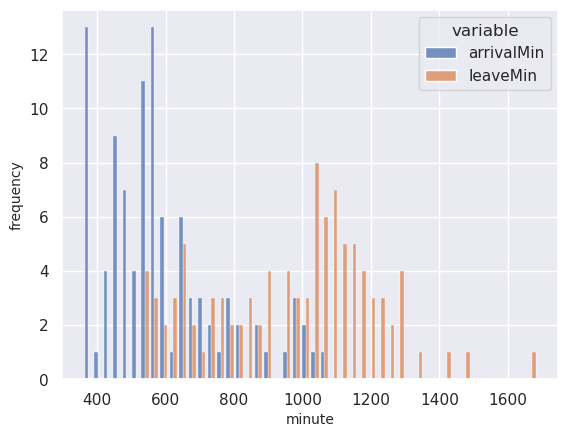

In [10]:
input_df_hist = pd.DataFrame(input_df['arrivalMin'])
input_df_hist['leaveMin']=input_df['arrivalMin'] + input_df['durationMin']

# plot melted dataframe in a single command
p=sns.histplot(input_df_hist.melt(), x='value', hue='variable',
             multiple='dodge', shrink=.75, bins=48)

p.set_xlabel("minute", fontsize = 10)
p.set_ylabel("frequency", fontsize = 10);

In [11]:
input_df_hist.head()

,arrivalMin,leaveMin
0,364,544
1,467,1097
2,480,750
3,535,1165
4,576,1026


In [12]:
input_df['arrivalMinGlobal'][0]

364

Main simulation loop

In [13]:
# Text wrap for nicer graph output
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

# SIMULATION PARAMETERS
NUM_DAYS = len(daily_sessions)
SIM_RUN_TIME = 1440*NUM_DAYS
CAR_ARR_TIME = 120
CAR_STAY_TIME = 300

sorted_events_q = []

#session output
session = []
#choice output
user_choice = []
#arrival time output
arrival_time = []
#departure time output
departure_time = []
#cartype output
car_type = []
#energy requested output
energyreq = []
#flex rate requested output
rate_flex = []
#asap rate requested output
rate_asap = []

models = ['Prius Prime','Model 3','Bolt EV', 'Kona','Model X 100 Dual','Clarity','Volt (second generation)','B-Class Electric Drive','Model S 100 Dual','Mustang Mach-E','Model S 90 Dual','Bolt EUV 2LT']

# import price lookup tables
# table_flex = pd.read_csv('/Users/areinaud/Desktop/table_flex.csv', index_col=0)
# table_asap = pd.read_csv('/Users/areinaud/Desktop/table_asap.csv', index_col=0)


def charger_station(env, run_time):
    
    user = 0
    next_leave_time = -1
    events_q = []

    # for plotting outputs
    leave_time_datalog = []
    num_flex = 0
    num_asap = 0
    num_leave_imm = 0
    num_leave_occ = 0

    # Time until first user arrives:
    yield env.timeout(input_df['arrivalMinGlobal'][0])
    # print('first step', str(env.now()))

    while True:
      
      # Car arrives 
      user += 1

      if user > input_df.shape[0]:
        break

      #cartype output        
      car = random.choices(models, weights = (151, 110, 86, 51, 42, 42, 28, 24, 20, 19, 15, 14))
      car_type.append(car)
      #session output        
      session.append(user)
      #arrival time output
      arrival_time.append(env.now)

      #energy asked by user (in Wh)    
      desired_energy = input_df['cumEnergy_Wh'][user-1]

      #energy required output
      energyreq.append(desired_energy)

      # print ("%s : Car %s arrived" % (str(env.now), user))
      events_q.append((int(env.now), "%s : Car %s arrived" % (str(env.now), user))) 
      inst_dept = int(env.now) + 1
    
      # generate stay duration
      stay_duration = input_df['durationMin'][user-1]
    
      print('curr_time = ', int(env.now))
      print('departure_time = ', int(env.now)+int(stay_duration))
      print('requested_energy = ', desired_energy)
    
      asap_price, flex_price = optimizer_main(curr_time=int(env.now), departure_time=int(env.now)+int(stay_duration), requested_energy=desired_energy, pwr_rate=6.6) #Divide by 1000 to have kWh

      #rates output
      charge_time = 30 * round((stay_duration)/30)
      #flex rate requested output
      rate_flex.append(flex_price)
      #asap rate requested output
      rate_asap.append(asap_price)

      
      if arrival_time[-1] > next_leave_time:
          leaveTime = int(env.now) + int(stay_duration)
          # print("leave time = ", leaveTime)
          choice = choice_function(asap_price, flex_price)
          if choice == 1:
            choice_name = 'SCHEDULED'
          elif choice == 2:
            choice_name ='REGULAR'
          else:
            choice_name = 'LEAVE'
          # print("choice = ", choice)
          #choice output
          user_choice.append(choice_name)


          if choice == 1:
              # print("User %s chose flex" % (user))
              events_q.append((arrival_time[-1]+3, "%s : User %s chose flex" % (arrival_time[-1]+3, user)))
              num_flex += 1  
              leave_time_datalog.append(stay_duration)
              next_leave_time = leaveTime
              # print ("%s : Car %s left" % (next_leave_time, user))
              events_q.append((next_leave_time, "%s : Car %s left" % (next_leave_time, user)))
#               yield env.timeout(3)
              #departure time output
              departure_time.append(next_leave_time)  
          elif choice == 2:
              # print("User %s chose ASAP" % (user))
              events_q.append((arrival_time[-1]+3, "%s : User %s chose ASAP" % (arrival_time[-1]+3, user))) 
              num_asap += 1
              
              leave_time_datalog.append(stay_duration)
              next_leave_time = leaveTime
              # print ("%s : User %s left" % (next_leave_time, user))
              events_q.append((next_leave_time, "%s : Car %s left" % (next_leave_time, user)))
#               yield env.timeout(3)
              #departure time output
              departure_time.append(next_leave_time) 

          elif choice == 3:
              #departure time output 
              departure_time.append(inst_dept) 
              
              # print("User %s chose to leave without charging" % (user))
              events_q.append((inst_dept, "%s : User %s chose to leave without charging" % (inst_dept, user))) 
              num_leave_imm += 1
#               yield env.timeout(3)

      else:

          #choice output
          choice_name = 'OCCUPIED'
          user_choice.append(choice_name)
          #departure time output 
          departure_time.append(inst_dept) # (env.now) 

          # print("User %s left because charger is occupied" % (user))
          events_q.append((inst_dept, "%s : User %s left because charger is occupied" % (inst_dept, user)))
          num_leave_occ += 1
#           yield env.timeout(3)
    
      # terminal segment
      if env.now >= run_time - 30 :
          events_q.sort(reverse = True)
          sorted_events_q = events_q
          
          # print timeline of events
          # while events_q:
          #     t = events_q.pop()
          #     print(t[1])
          
          # plot data
          x = np.array([x for x in range(len(leave_time_datalog))])

          figure(figsize = (10, 4))
          plt.plot(x, leave_time_datalog, linewidth=1)
          plt.xlabel("Number of arrivals")  # add X-axis label
          plt.ylabel("Stay duration")  # add Y-axis label
          plt.title("Number of Arrivals vs Stay duration")  # add title
          plt.show()

          fig = plt.figure()
          ax = fig.add_axes([0,0,1,1])
          choice = ['Flex', 'ASAP', 'Leave', 'Leave\n(occupied)']
          frequency = [num_flex, num_asap, num_leave_imm, num_leave_occ]
          ax.bar(choice, frequency)
          plt.xlabel("Agent Choice")  # add X-axis label
          plt.ylabel("Frequency of choice")  # add Y-axis label
          plt.title("Agent Choice vs Frequency")
          # plt.rcParams["figure.autolayout"] = True
          # wrap_labels(ax, 500)
          # ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
          plt.show()
          
          break
    
          #yield env.timeout(random.randint(30,CAR_ARR_TIME)) # random interval for next arrival
      yield env.timeout(input_df['arrivalMinGlobal'][user] - input_df['arrivalMinGlobal'][user-1])

    return[session]
    # return[user_choice]
    # return[arrival_time]
    # return[departure_time]
    # return[car_type]
    # return[energyreq]
    # return[rate_flex]
    # return[rate_asap]


def choice_function(asap_price, flex_price):
    # print("leave time = ", leave_time)
    # print("curr time = ", curr_time)
#     charge_time = 30 * round((leave_time - curr_time)/30)
    # print("charge_time = ", charge_time)
    # print('charge level = ', charge_level)
    # read price from tables
    # print(table_asap)
#     asap_price = table_asap[str(desired_energy)][charge_time]
#     flex_price = table_flex[str(desired_energy)][charge_time]
    # choose lower price
    if asap_price > flex_price:
      choice = 1
    else: 
      choice = 2
    if random.uniform(0, 1) > 0.9:
      choice = 3
    return choice



def first_process(env, run_length):
    yield env.process(charger_station(env, run_length))



# MAIN
env = simpy.Environment()

env.process(first_process(env, SIM_RUN_TIME))   
env.run(SIM_RUN_TIME + 10)


curr_time =  364
departure_time =  544
requested_energy =  20
curr_time =  467
departure_time =  1097
requested_energy =  40
curr_time =  480
departure_time =  750
requested_energy =  30
curr_time =  535
departure_time =  1165
requested_energy =  20
curr_time =  576
departure_time =  1026
requested_energy =  50
curr_time =  631
departure_time =  1141
requested_energy =  30
curr_time =  642
departure_time =  1212
requested_energy =  60
curr_time =  977
departure_time =  1277
requested_energy =  20
curr_time =  1016
departure_time =  1226
requested_energy =  20
curr_time =  1045
departure_time =  1225
requested_energy =  10
curr_time =  1899
departure_time =  2079
requested_energy =  10
curr_time =  1906
departure_time =  2416
requested_energy =  50
curr_time =  1910
departure_time =  2120
requested_energy =  20
curr_time =  1930
departure_time =  2200
requested_energy =  30
curr_time =  1998
departure_time =  2628
requested_energy =  70
curr_time =  2008
departure_time =  2308
requested

KeyError: 100

# Output Table

Generate dataframe

In [14]:
df = pd.DataFrame({'session': session, 'choice': user_choice, 'arrival time': arrival_time, 'departure time': departure_time})
df['durationHrs'] = (df['departure time'] - df['arrival time']) / 60
df['arrival time'] = pd.Timestamp(2022, 4, 4, 9) + pd.TimedeltaIndex(df['arrival time'], unit='m')
df['departure time'] = pd.Timestamp(2022, 4, 4, 9) + pd.TimedeltaIndex(df['departure time'], unit='m')

In [15]:
df['vehicle_model'] = car_type

df['energy_requested'] = energyreq

df['rate_scheduled'] = rate_flex
df['rate_regular'] = rate_asap

df['sch_centsPerHr'] = ((df['rate_scheduled']*100)/df['durationHrs']).round(decimals=0)
df['reg_centsPerHr'] = ((df['rate_regular']*100)/df['durationHrs']).round(decimals=0)

df['energyReq_Wh'] = df['energy_requested']*1000

df = df.drop('rate_scheduled', 1)
df = df.drop('rate_regular', 1)
df = df.drop('energy_requested', 1)

df.head()

,session,choice,arrival time,departure time,durationHrs,vehicle_model,sch_centsPerHr,reg_centsPerHr,energyReq_Wh
0,1,SCHEDULED,2022-04-04 15:04:00,2022-04-04 18:04:00,3.000000,[Volt (second generation)],666.0,720.0,20000
1,2,OCCUPIED,2022-04-04 16:47:00,2022-04-04 16:48:00,0.016667,[Bolt EV],121791.0,119859.0,40000
2,3,OCCUPIED,2022-04-04 17:00:00,2022-04-04 17:01:00,0.016667,[Prius Prime],119843.0,120022.0,30000
3,4,OCCUPIED,2022-04-04 17:55:00,2022-04-04 17:56:00,0.016667,[Bolt EV],122395.0,119618.0,20000
4,5,LEAVE,2022-04-04 18:36:00,2022-04-04 18:37:00,0.016667,[Model 3],126769.0,142389.0,50000


In [16]:
def hr_func(ts):
    return ts.hour
df['arrival_hour'] = df['arrival time'].apply(hr_func)
df['departure_hour'] = df['departure time'].apply(hr_func)

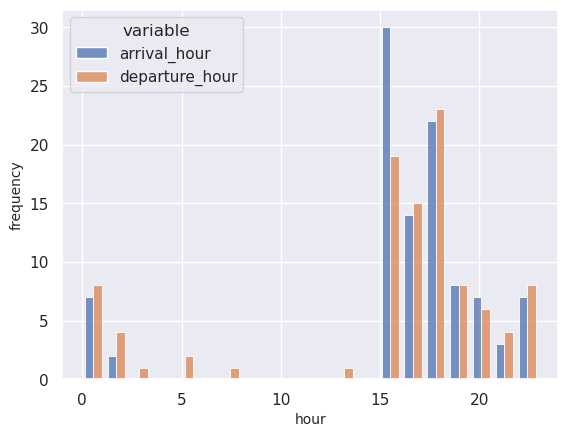

In [17]:
df_hist = pd.DataFrame(df['arrival_hour'])
df_hist['departure_hour']=df['departure_hour']

# plot melted dataframe in a single command
p=sns.histplot(df_hist.melt(), x='value', hue='variable',
             multiple='dodge', shrink=.75, bins=20)

p.set_xlabel("hour", fontsize = 10)
p.set_ylabel("frequency", fontsize = 10);

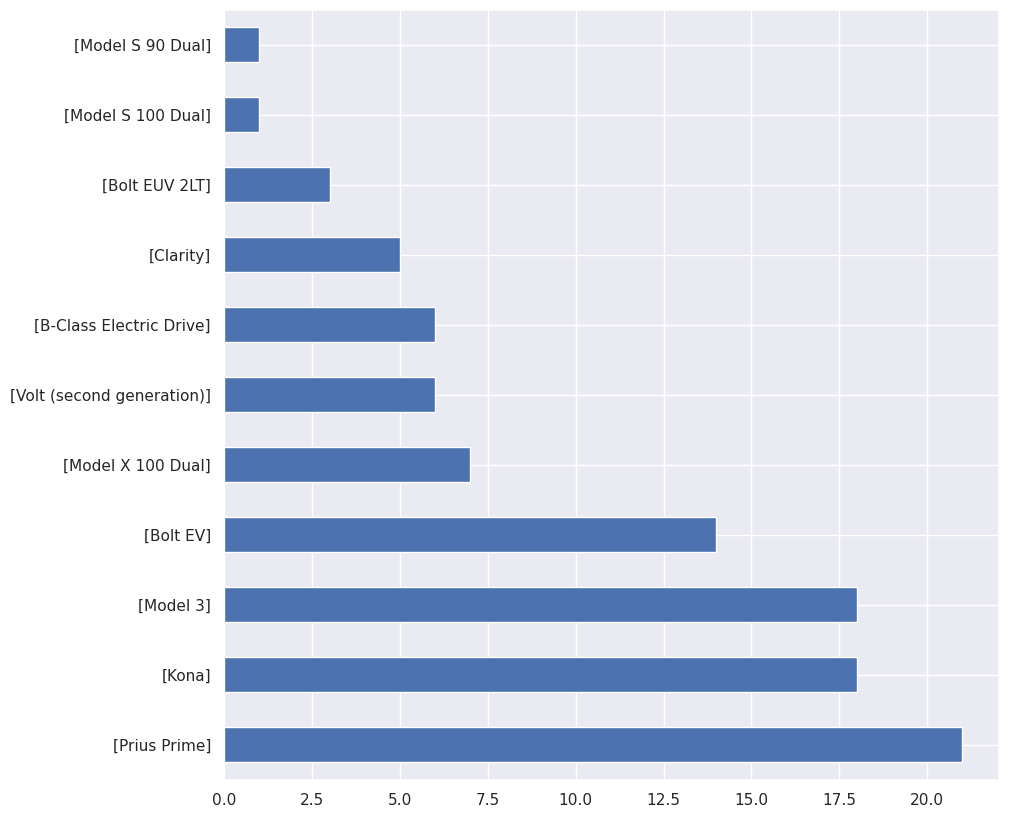

In [18]:
df['vehicle_model'].value_counts().plot(kind='barh', figsize=(10, 10));

In [19]:
df = df[df.choice != 'OCCUPIED']

View consolidated simulation dataframe

In [20]:
df.head()

,session,choice,arrival time,departure time,durationHrs,vehicle_model,sch_centsPerHr,reg_centsPerHr,energyReq_Wh,arrival_hour,departure_hour
0,1,SCHEDULED,2022-04-04 15:04:00,2022-04-04 18:04:00,3.000000,[Volt (second generation)],666.0,720.0,20000,15,18
4,5,LEAVE,2022-04-04 18:36:00,2022-04-04 18:37:00,0.016667,[Model 3],126769.0,142389.0,50000,18,18
5,6,LEAVE,2022-04-04 19:31:00,2022-04-04 19:32:00,0.016667,[Kona],121981.0,119699.0,30000,19,19
6,7,SCHEDULED,2022-04-04 19:42:00,2022-04-05 05:12:00,9.500000,[Bolt EV],280.0,371.0,60000,19,5
10,11,SCHEDULED,2022-04-05 16:39:00,2022-04-05 19:39:00,3.000000,[Model 3],660.0,705.0,10000,16,19


Arrival and departure frequency plot

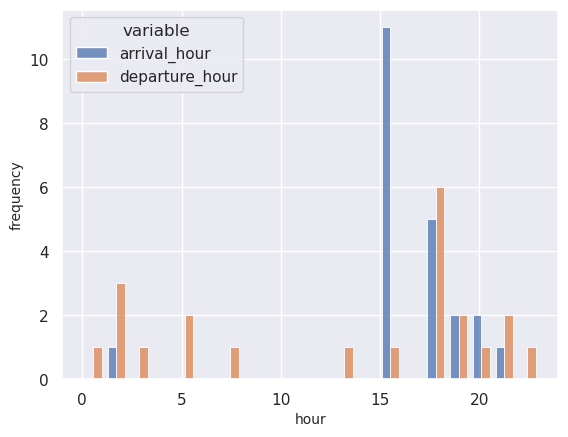

In [21]:
df_hist = pd.DataFrame(df['arrival_hour'])
df_hist['departure_hour']=df['departure_hour']

# plot melted dataframe in a single command
p=sns.histplot(df_hist.melt(), x='value', hue='variable',
             multiple='dodge', shrink=.75, bins=20)

p.set_xlabel("hour", fontsize = 10)
p.set_ylabel("frequency", fontsize = 10);

Plot of vehicle types

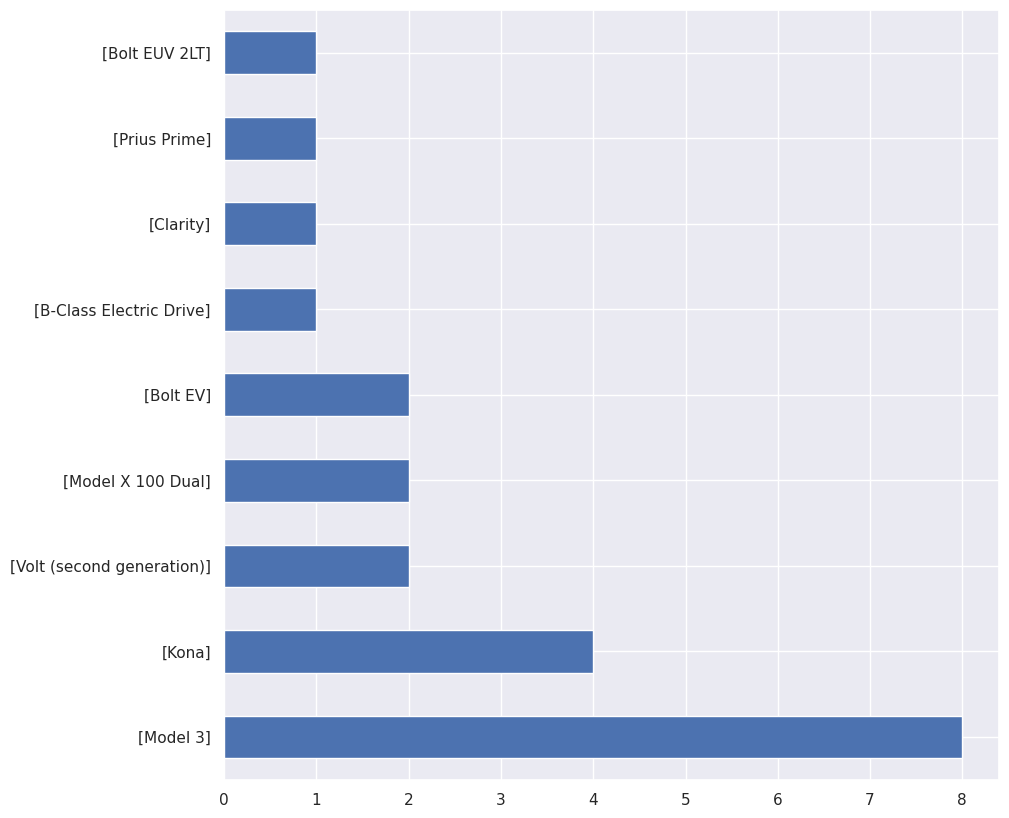

In [22]:
df['vehicle_model'].value_counts().plot(kind='barh', figsize=(10, 10));

In [23]:
df['choice'].value_counts()

SCHEDULED    14
LEAVE         4
REGULAR       4
Name: choice, dtype: int64

Distribution of user choice

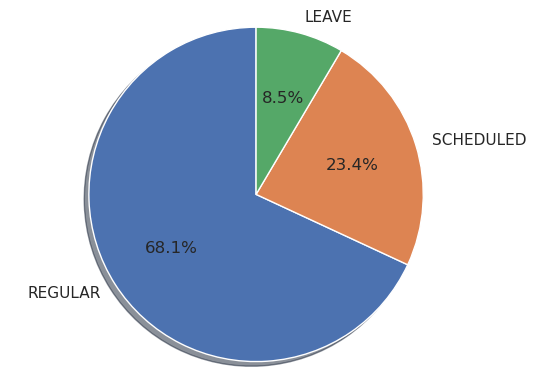

In [24]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'REGULAR', 'SCHEDULED', 'LEAVE'
sizes = [64, 22, 8]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Plot session times

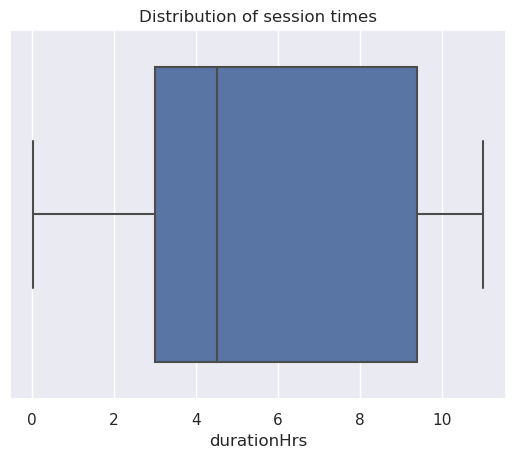

In [25]:
sns.boxplot(x= df['durationHrs']) 
plt.title("Distribution of session times");

Plot energy Requirements

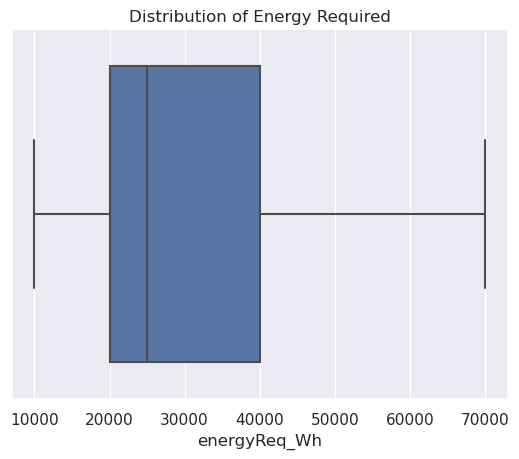

In [26]:
sns.boxplot(x= df['energyReq_Wh']) 
plt.title("Distribution of Energy Required");

## Data visualization(New dataset) -- 10/21/2022

In [1]:
# Text wrap for nicer graph output
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots


In [2]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [3]:
df1 = pd.read_csv("./data/Sessions2_20221020.csv")

In [4]:
# df1

In [5]:

df1['connectTime'] = pd.to_datetime(df1['connectTime'], errors='coerce')
[df1_year, df1_month] = [df1['connectTime'].dt.year, df1['connectTime'].dt.month]
year_month = np.array([df1_year, df1_month]).T

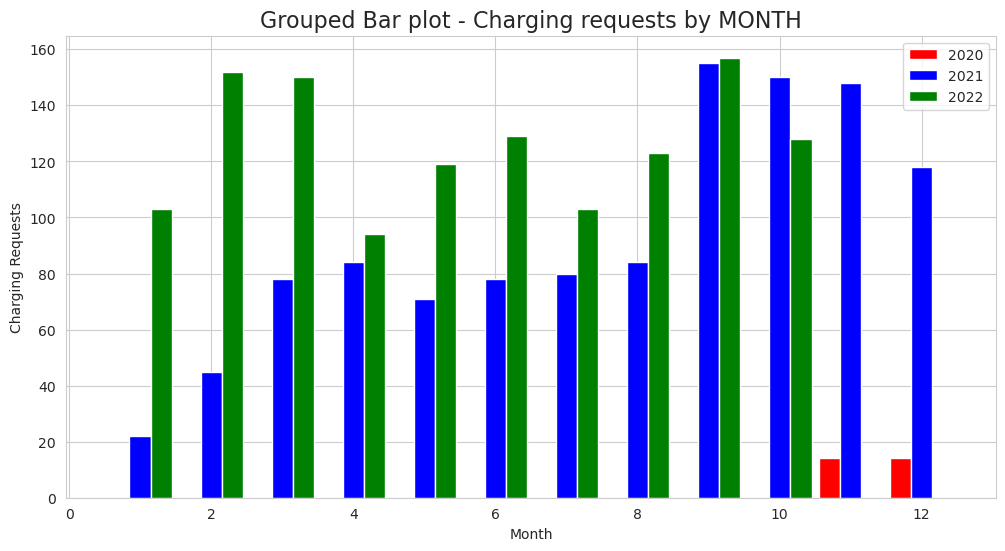

In [6]:
# Year_month
requests_2020 = np.unique(year_month[year_month[:, 0] == 2020][:, 1], return_counts=True)
requests_2021 = np.unique(year_month[year_month[:, 0] == 2021][:, 1], return_counts=True)
requests_2022 = np.unique(year_month[year_month[:, 0] == 2022][:, 1], return_counts=True)
requests_2020 = [np.array([1,2,3,4,5,6,7,8,9,10,11,12]),
                 np.array([0,0,0,0,0,0,0,0,0,0,14,14])]
requests_2022 = (np.array([1,2,3,4,5,6,7,8,9,10,0,0]),
                 np.array([103,152,150,94,119,129,103,123,157,128,0,0]))
xticks = np.arange(len(requests_2020[0])) + 1

f,ax = plt.subplots(figsize=(12, 6))
#
ax.bar(xticks-0.3, height=requests_2020[1], width=0.3, color='red', label='2020')
ax.bar(xticks, height=requests_2021[1], width=0.3, color='blue', label='2021')
ax.bar(xticks+0.3, height=requests_2022[1], width=0.3, color='green', label='2022')

ax.set_title("Grouped Bar plot - Charging requests by MONTH", fontsize=16)
ax.set_xlabel("Month")
ax.set_ylabel("Charging Requests")

ax.legend()
plt.show()

In [7]:
# Arrival Time Distribution
df1_hour= df1['connectTime'].dt.hour
arrival_hour = df1_hour
arrival_hour_count = pd.value_counts(arrival_hour)

/tmp/ipykernel_10257/1994673354.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(arrival_hour)


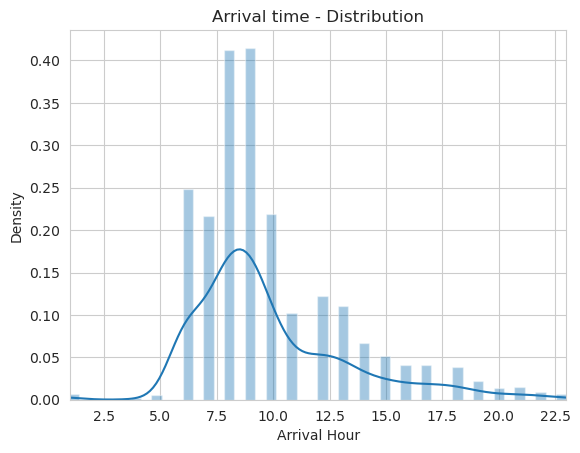

In [8]:
g = sns.distplot(arrival_hour)
g.set_title('Arrival time - Distribution')
g.set_xlabel('Arrival Hour')
g.set(xlim=(1,23))
plt.show()

/tmp/ipykernel_10257/651384972.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f = sns.distplot(arrival_hour, hist_kws=kwargs, kde_kws=kwargs)


[(1.0, 23.0)]

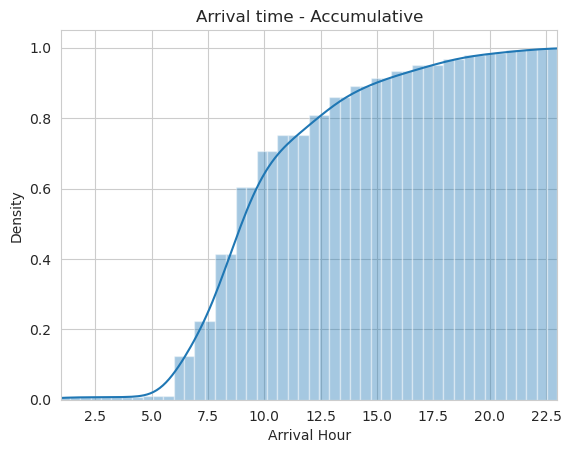

In [9]:
kwargs = {'cumulative': True}
f = sns.distplot(arrival_hour, hist_kws=kwargs, kde_kws=kwargs)
f.set_title('Arrival time - Accumulative')
f.set_xlabel('Arrival Hour')
f.set(xlim=(1,23))

In [10]:
# Charging Time Distribution

## Visualize the relations between delivered energy (column name: cumEnergy_Wh) and several other key metrics

### Energy Delivered -- Choice

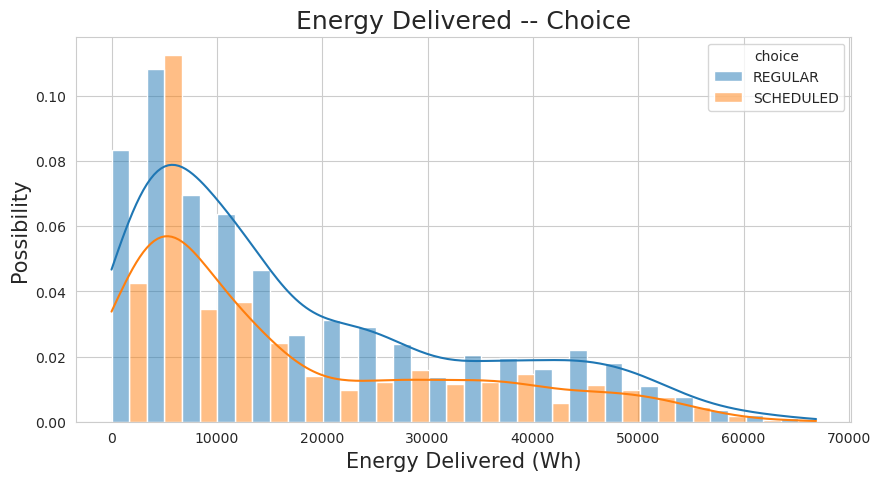

In [11]:
df1 = pd.read_csv("./data/Sessions2_20221020.csv")
f_enerDlv_choice, ax = plt.subplots(figsize=(10,5))
f_enerDlv_choice = sns.histplot(df1, x=df1['cumEnergy_Wh'],
                                hue=df1['choice'],
                                stat='probability',           # The y-axis is "Count" when stat is set as Default
                                multiple='dodge',
                                kde=True,
                                bins=20)
ax.set_title('Energy Delivered -- Choice', fontsize=18)
ax.set_xlabel('Energy Delivered (Wh)',fontsize=15)
ax.set_ylabel('Possibility', fontsize=15)
plt.show()

### Energy Delivered -- Duration Hours

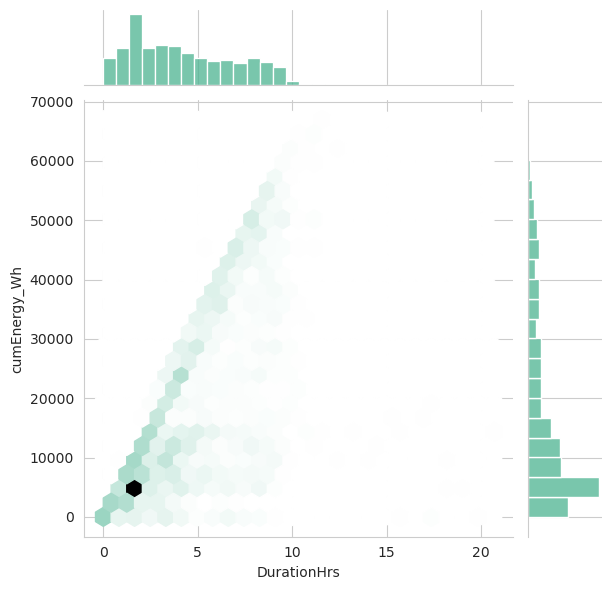

In [12]:
df1 = pd.read_csv("./data/Sessions2_20221020.csv")
f_enerDlv_durMaxChar1 = sns.jointplot(data=df1,
                                      x="DurationHrs",
                                      y="cumEnergy_Wh",
                                      kind="hex",
                                      color="#4CB391")
plt.show()

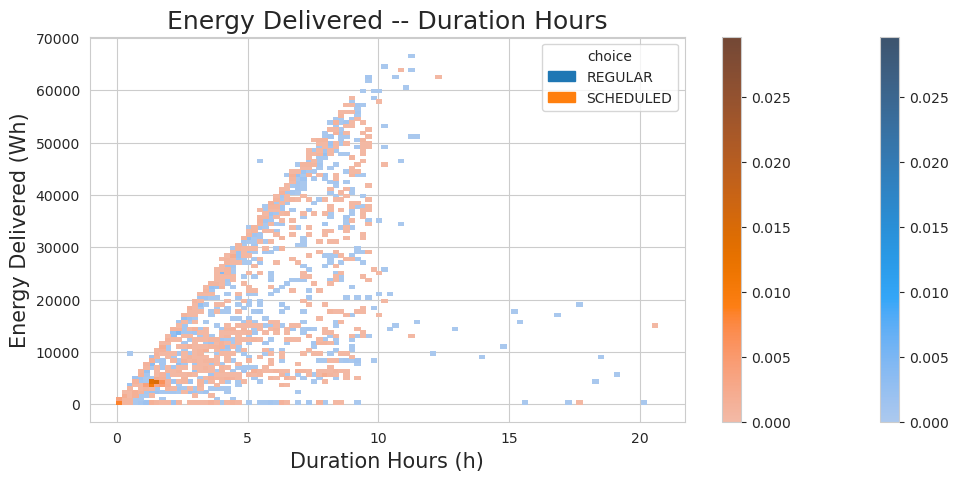

In [13]:
df1 = pd.read_csv("./data/Sessions2_20221020.csv")
f_enerDlv_dur, ax = plt.subplots(figsize=(12,5))
f_enerDlv_dur = sns.histplot(df1, x=df1['DurationHrs'],
                             y=df1['cumEnergy_Wh'],
                             hue=df1['choice'],
                             stat='probability',           # The y-axis is "Count" when stat is set as Default
                             multiple='layer',
                             kde=True,
                             cbar=True,
                             bins=100)
ax.set_title('Energy Delivered -- Duration Hours', fontsize=18)
ax.set_xlabel('Duration Hours (h)',fontsize=15)
ax.set_ylabel('Energy Delivered (Wh)', fontsize=15)
# f_enerDlv_dur, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
# ax1 = sns.histplot(df1, x=df1['DurationHrs'],
#                     y=df1['cumEnergy_Wh'],
#                     # hue=df1['choice'],
#                     stat='probability',           # The y-axis is "Count" when stat is set as Default
#                     # multiple='dodge',
#                     kde=True,
#                     # cbar=True,
#                     bins=80)
# ax1.set_xlabel('Duration Hours (h)',fontsize=15)
# ax1.set_ylabel('Energy Delivered (Wh)', fontsize=15)
# ax2 = sns.histplot(df1, x=df1['DurationHrs'],
#                     y=df1['cumEnergy_Wh'],
#                     # hue=df1['choice'],
#                     stat='probability',           # The y-axis is "Count" when stat is set as Default
#                     # multiple='dodge',
#                     kde=True,
#                     # cbar=True,
#                     bins=80)
# ax2.set_xlabel('Duration Hours (h)',fontsize=15)
# ax2.set_ylabel('Energy Delivered (Wh)', fontsize=15)
plt.show()

### Energy Delivered -- Arrival time

In [14]:
df1 = pd.read_csv("./data/Sessions2_20221020.csv")

# Arrival Time Distribution
df1['connectTime'] = pd.to_datetime(df1['connectTime'],
                                    errors='coerce')

df1 = df1.resample('10Min',on='connectTime').sum()                      # Change the minimum unit of resampling to change the accuracy

df1['cumEnergy_Wh'] = df1.groupby(['connectTime'])['cumEnergy_Wh'].sum()
df1 = df1.drop(df1[(df1['cumEnergy_Wh']==0)].index).reset_index(level=['connectTime'])
df1_arr_time= df1['connectTime'].dt.hour \
              + df1['connectTime'].dt.minute/60


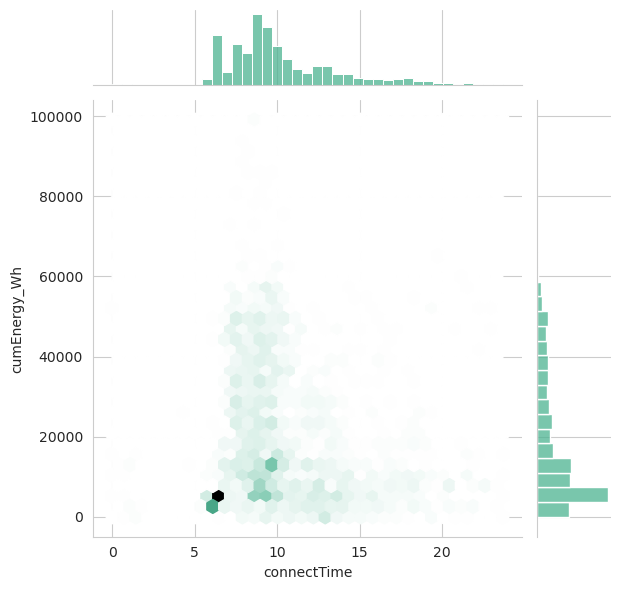

In [15]:
f_enerDlv_arrvl1 = sns.jointplot(data=df1,
                                 x=df1_arr_time,
                                 y="cumEnergy_Wh",
                                 kind="hex",
                                 color="#4CB391")
plt.show()

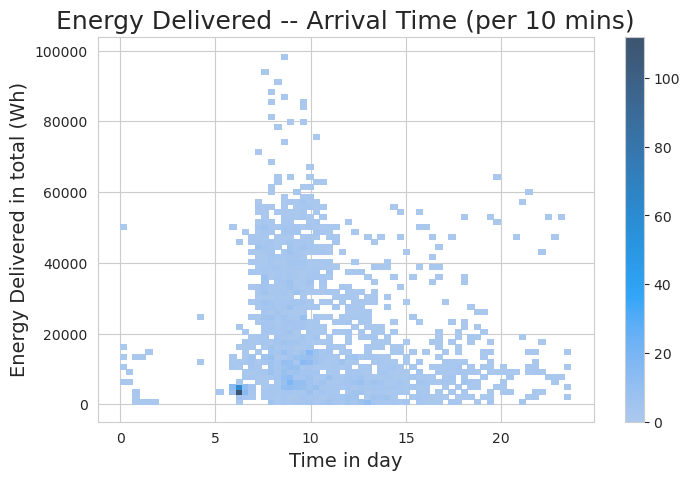

In [16]:
f_enerDlv_arrvl, ax = plt.subplots(figsize=(8,5))
f_enerDlv_arrvl = sns.histplot(df1,
                               x=df1_arr_time,
                               y='cumEnergy_Wh',
                               bins=70,
                               cbar=True)
ax.set_title('Energy Delivered -- Arrival Time (per 10 mins)', fontsize=18)
ax.set_xlabel('Time in day', fontsize=14)
ax.set_ylabel('Energy Delivered in total (Wh)', fontsize=14)
plt.show()

### Energy Delivered -- Departure Time

In [17]:
df1 = pd.read_csv("./data/Sessions2_20221020.csv")

# Departure Time Distribution
df1['connectTime'] = pd.to_datetime(df1['connectTime'],
                                    errors='coerce')
df1 = df1.resample('10Min',on='connectTime').sum()                      # Change the minimum unit of resampling to change the accuracy

df1['cumEnergy_Wh'] = df1.groupby(['connectTime'])['cumEnergy_Wh'].sum()
df1 = df1.drop(df1[(df1['cumEnergy_Wh']==0)].index).reset_index(level=['connectTime'])
df1_dept_time= df1['connectTime'].dt.hour \
              + df1['connectTime'].dt.minute/60 \
              + df1['DurationHrs']

# If a user stays overnight, subtract 24/48 hours from the departure time
df1_dept_time[(df1_dept_time >= 48)] = [df1_dept_time[(df1_dept_time >= 48)] - 48]
df1_dept_time[(df1_dept_time >= 24)] = [df1_dept_time[(df1_dept_time >= 24)] - 24]

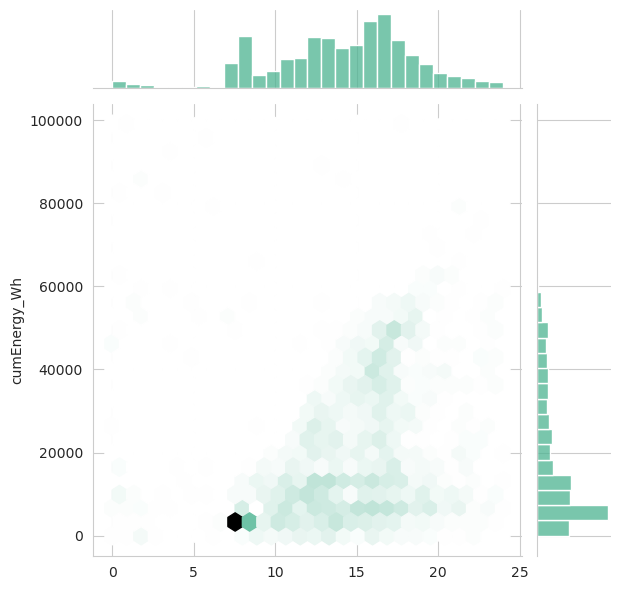

In [18]:
f_enerDlv_dept1 = sns.jointplot(data=df1,
                               x=df1_dept_time,
                               y='cumEnergy_Wh',
                               kind="hex",
                               color="#4CB391")
plt.show()

/tmp/ipykernel_10257/3985704945.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  f_enerDlv_dept = sns.histplot(df1,


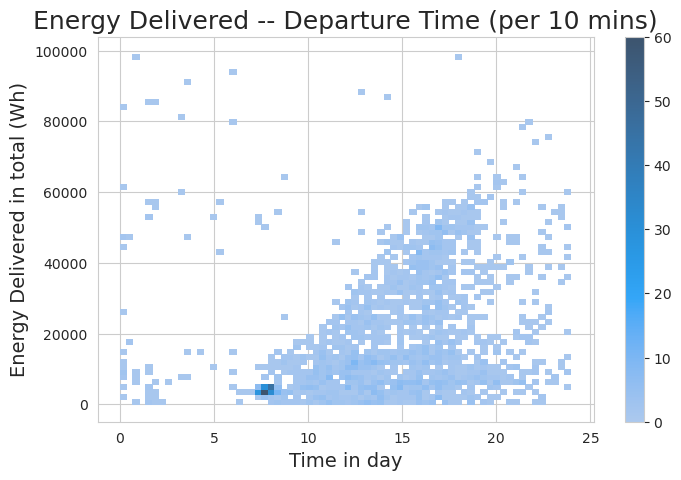

In [19]:
f_enerDlv_dept, ax = plt.subplots(figsize=(8,5))
f_enerDlv_dept = sns.histplot(df1,
                              x=df1_dept_time,
                              y='cumEnergy_Wh',
                              palette="ch:s=-.2,r=.6",
                              bins=70,
                              cbar=True)
ax.set_title('Energy Delivered -- Departure Time (per 10 mins)', fontsize=18)
ax.set_xlabel('Time in day', fontsize=14)
ax.set_ylabel('Energy Delivered in total (Wh)', fontsize=14)
plt.show()

### Energy Delivered -- Duration & Max Charging Rate

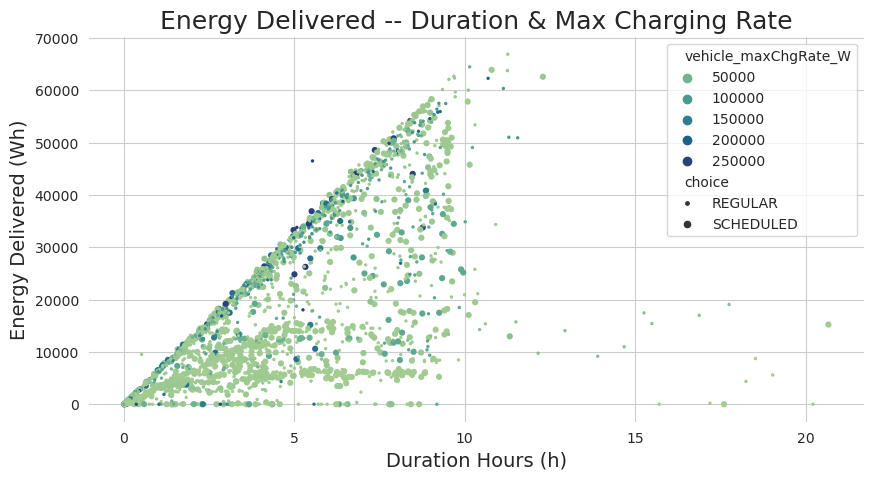

In [25]:
df1 = pd.read_csv("./data/Sessions2_20221020.csv")

# Delete one user's car with too large charging rate of 7,680 kW
# The charging power of Tesla Model Y according Tesla database:
# Charge Power = 11 kW AC    |    Fastcharge Power (max) = 250 kW DC
df1 = df1.drop(df1[(df1['vehicle_maxChgRate_W']==7680000)].index)

f_enerDlv_durMaxChar, ax = plt.subplots(figsize=(10,5))
sns.despine(f_enerDlv_durMaxChar, left=True, bottom=True)
f_enerDlv_durMaxChar = sns.scatterplot(data=df1,
                                       x="DurationHrs",
                                       y="cumEnergy_Wh",
                                       hue="vehicle_maxChgRate_W",
                                       size="choice",
                                       palette='crest',
                                       sizes=(20, 6),
                                       linewidth=0,
                                       ax=ax)
ax.set_title('Energy Delivered -- Duration & Max Charging Rate', fontsize=18)
ax.set_xlabel('Duration Hours (h)', fontsize=14)
ax.set_ylabel('Energy Delivered (Wh)', fontsize=14)
plt.show()

## Station-level power demand

### Station-level power demand over station ID


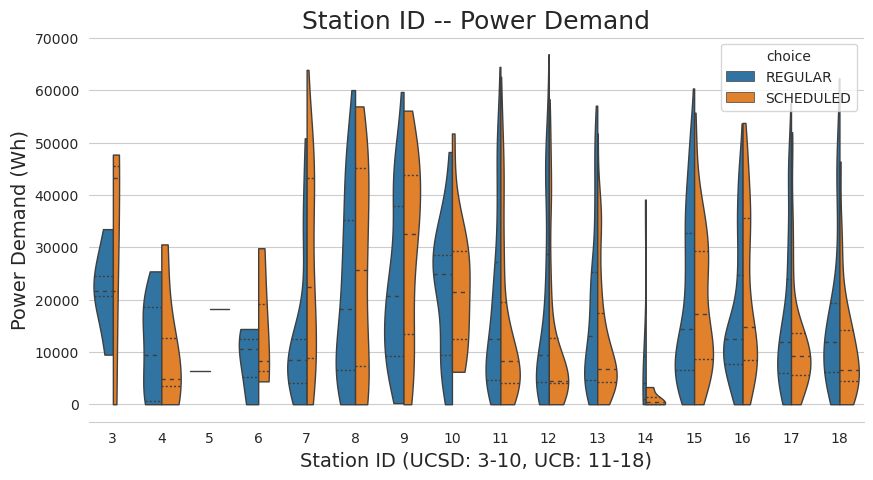

In [24]:
df1 = pd.read_csv("./data/Sessions2_20221020.csv")
f_stationId_Dem, ax = plt.subplots(figsize=(10,5))
f_stationId_Dem = sns.violinplot(data=df1,
                                 x='stationId',
                                 y='cumEnergy_Wh',
                                 hue='choice',
                                 split=True,
                                 cut=0,
                                 inner='quart',       # Set inner to 'stick' to see trend details
                                 linewidth=1)
sns.despine(left=True)
ax.set_title('Station ID -- Power Demand', fontsize=18)
ax.set_xlabel('Station ID (UCSD: 3-10, UCB: 11-18)', fontsize=14)
ax.set_ylabel('Power Demand (Wh)', fontsize=14)
plt.show()

### Station-level power demand over time

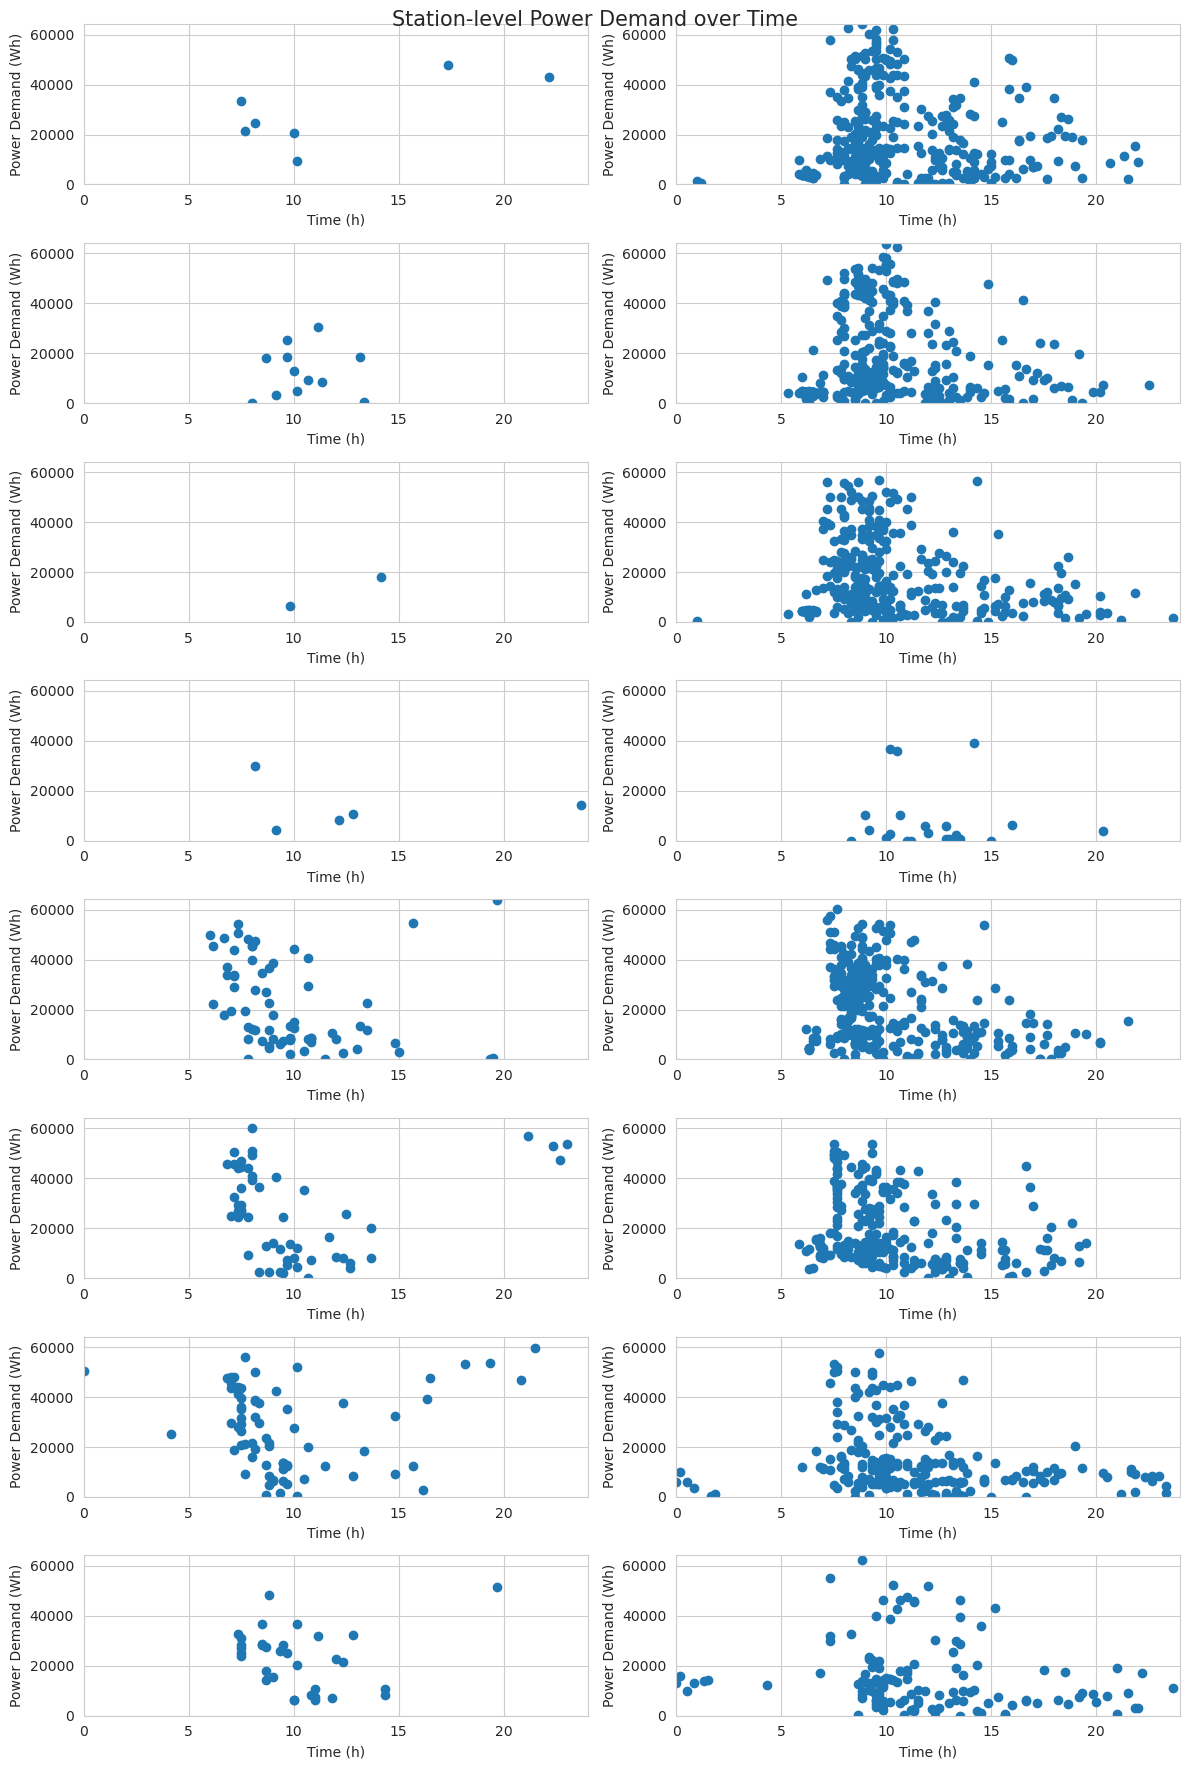

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the data
df1 = pd.read_csv("./data/Sessions2_20221020.csv")
# Arrival Time Distribution
df1['connectTime'] = pd.to_datetime(df1['connectTime'],
                                    errors='coerce')

prepare_df = locals()
for i in range(3,19):
    df_ = 'df_' + str(i)
    prepare_df['df_' + str(i)] = df1[df1['stationId'].isin([i])]
    prepare_df['df_' + str(i)] = prepare_df['df_' + str(i)].resample('10Min',on='connectTime').sum()
    # Change the minimum unit of resampling to change the accuracy
    prepare_df['df_' + str(i)]['cumEnergy_Wh'] = prepare_df['df_' + str(i)].groupby(['connectTime'])['cumEnergy_Wh'].sum()
    prepare_df['df_' + str(i)] = prepare_df['df_' + str(i)].drop(prepare_df['df_' + str(i)][(prepare_df['df_' + str(i)]['cumEnergy_Wh']==0)].index).reset_index(level=['connectTime'])
    prepare_df['df_' + str(i)]['connectTime']= prepare_df['df_' + str(i)]['connectTime'].dt.hour\
                                               + prepare_df['df_' + str(i)]['connectTime'].dt.minute/60

y_max = prepare_df[df_]['cumEnergy_Wh'].max() + 2000

f_stationId_Dem_Time, ax = plt.subplots(8,2,figsize=(12,18))
for j in range(3,11):
    ax[j-3][0].scatter(data=prepare_df['df_'+str(j)], x='connectTime', y='cumEnergy_Wh', label='Station '+str(j))
    ax[j-3][0].set_xlabel('Time (h)', fontsize=10)
    ax[j-3][0].set_ylabel('Power Demand (Wh)', fontsize=10)
    ax[j-3][0].set_xlim([0, 24])
    ax[j-3][0].set_ylim([0, y_max])

for j in range(11,19):
    ax[j-11][1].scatter(data=prepare_df['df_'+str(j)], x='connectTime', y='cumEnergy_Wh', label='Station '+str(j))
    ax[j-11][1].set_xlabel('Time (h)', fontsize=10)
    ax[j-11][1].set_ylabel('Power Demand (Wh)', fontsize=10)
    ax[j-11][1].set_xlim([0, 24])
    ax[j-11][1].set_ylim([0, y_max])

plt.suptitle('Station-level Power Demand over Time', fontsize=15)
plt.tight_layout()
plt.show()


In [3]:
# import sys, os
# # sys.path.insert(1, os.getcwd() + '\..\src')
# sys.path.insert(1, os.getcwd() + '/../src')
# from viz import *
#
#
#
#
# df1 = pd.read_csv("../data/Sessions2.csv")
# energyDdelivered_hbbbhjjk(df1)